In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [ ]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import data_processing, compute_anomalies, \
                            compute_forced_response, compute_variance, \
                            merge_runs, stack_runs, numpy_to_torch, standardize, build_training_and_test_sets

from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred
from leave_one_out import leave_one_out_single, leave_one_out_procedure
from cross_validation import cross_validation_procedure

In [3]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [4]:
# define pytorch precision
dtype = torch.float32

data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# stack runs for each model
x, y, vars = stack_runs(x,y,vars,time_period=33,lon_size=lon_size,lat_size=lat_size,dtype=dtype)

# convert all data to pytorch tensors with precision float32
# x = {key: elt.to(torch.float16) for key, elt in x.items()}
# y = {key: elt.to(torch.float16) for key, elt in y.items()}
# vars = {key: elt.to(torch.float16) for key, elt in vars.items()}

# stack runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/home/vcohen/cope/src/preprocessing.py:109: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:152: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:156: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [5]:
m0 = 'CMCC-CM2-SR5'

training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33,dtype=dtype)

In [6]:
from algorithms import ridge_regression, ridge_regression_low_rank, low_rank_projection, \
                        prediction, train_robust_weights_model, compute_weights


In [12]:
# compute ridge regressor
W_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_ridge[np.ix_(notnan_idx,notnan_idx)] = ridge_regression(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 70
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 10
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 5
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

In [13]:
lambda_tmp = 100.0
mu_tmp = 5000.0


# compute ridge regressor
w_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
w_ridge[np.ix_(notnan_idx,notnan_idx)] = ridge_regression(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=lambda_tmp, dtype=dtype)

# compute low rank ridge regressor
r = 10
w_ridge_lr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
w_ridge_lr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=lambda_tmp, dtype=dtype)

# compute robust ridge regressor
w_robust  = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,\
                                                       rank=None,lambda_= lambda_tmp,mu_=mu_tmp,\
                                                       lr=1e-5,nb_iterations=30,dtype=dtype, verbose=True)

# compute robust ridge regressor low rank (low-rank constraints)
w_robust_lr  = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,\
                                                       rank=10,lambda_= lambda_tmp,mu_=mu_tmp,\
                                                       lr=1e-5,nb_iterations=30,dtype=dtype, verbose=True)

Iteration  0 : Loss function :  65852.9765625
Iteration  1 : Loss function :  60070.39453125
Iteration  2 : Loss function :  57080.61328125
Iteration  3 : Loss function :  54526.85546875
Iteration  4 : Loss function :  52177.99609375
Iteration  5 : Loss function :  50014.875
Iteration  6 : Loss function :  48036.80078125
Iteration  7 : Loss function :  46246.77734375
Iteration  8 : Loss function :  44648.4921875
Iteration  9 : Loss function :  43242.0
Iteration  10 : Loss function :  42020.79296875
Iteration  11 : Loss function :  40971.34375
Iteration  12 : Loss function :  40074.90234375
Iteration  13 : Loss function :  39310.25
Iteration  14 : Loss function :  38656.31640625
Iteration  15 : Loss function :  38093.94921875
Iteration  16 : Loss function :  37606.73828125
Iteration  17 : Loss function :  37181.17578125
Iteration  18 : Loss function :  36806.37109375
Iteration  19 : Loss function :  36473.734375
Iteration  20 : Loss function :  36176.4609375
Iteration  21 : Loss functio

/tmp/ipykernel_3787/3508824824.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(training_models, rotation=-90)
/tmp/ipykernel_3787/3508824824.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(training_models, rotation=-90)


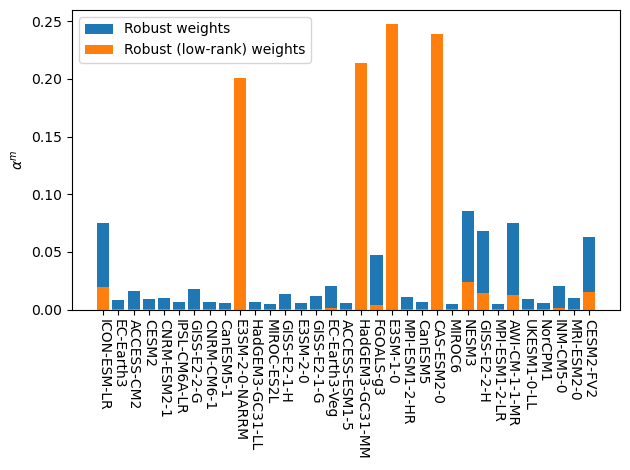

In [14]:
weights_robust = compute_weights(training_models,w_robust,x,y,notnan_idx,lambda_=lambda_tmp,mu_=mu_tmp)
weights_robust_lr = compute_weights(training_models,w_robust_lr,x,y,notnan_idx,lambda_=lambda_tmp,mu_=mu_tmp)

# plot the weights
    

plt.close('all')
################# plot the rmse #################
fig, ax = plt.subplots()

# plot robust weights
ax.bar(training_models, list(weights_robust.values()),label='Robust weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(training_models, rotation=-90)

# plot robust weights low rank
# plt.add_subplot(fig, ax, 1, training_models, weights_robust, 'Robust low-rank', 'b')
ax.bar(training_models, list(weights_robust_lr.values()),label='Robust (low-rank) weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(training_models, rotation=-90)

plt.tight_layout()
# plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

In [16]:
# compute predictions
# build test set
x_test_tmp = x[m0]
y_test_tmp = y[m0]

# ridge
y_pred_ridge = prediction(x_test_tmp, W_ridge,notnan_idx, nan_idx)

# low rank ridge
y_pred_ridge_lr = prediction(x_test_tmp, W_rrr,notnan_idx, nan_idx)

# robust
y_pred_robust = prediction(x_test_tmp, w_robust,notnan_idx, nan_idx)

# robust low rank ridge regression
y_pred_robust_lr= prediction(x_test_tmp, w_robust_lr,notnan_idx, nan_idx)


In [18]:
from matplotlib import animation

time_period=33

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure(figsize=(24,16))

ax0 = fig0.add_subplot(2, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(2, 3, 2)        
ax1.set_title(r'Ridge regression', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

ax2 = fig0.add_subplot(2, 3, 3)        
ax2.set_title(r'Low rank ridge regression', size=7,pad=3.0)
ax2.set_xlabel(r'x', size=7)
ax2.set_ylabel(r'y', size=7)

ax3 = fig0.add_subplot(2, 3, 5)        
ax3.set_title(r'Robust regression', size=7,pad=3.0)
ax3.set_xlabel(r'x', size=7)
ax3.set_ylabel(r'y', size=7)

ax4 = fig0.add_subplot(2, 3, 6)        
ax4.set_title(r'Low rank Robust regression', size=7,pad=3.0)
ax4.set_xlabel(r'x', size=7)
ax4.set_ylabel(r'y', size=7)

# get first run of the test set
idx_run = 1
y_to_plot_target = y_test_tmp[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_pred_ridge[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # ridge
y_to_plot_pred_ridge_lr = y_pred_ridge_lr[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # ridge low rank
y_to_plot_pred_robust = y_pred_robust[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # robust 
y_to_plot_pred_robust_lr = y_pred_robust_lr[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # robust low rank

im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge_lr,vmin=-1.0,vmax=2.0)
im3 = ax3.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust,vmin=-1.0,vmax=2.0)
im4 = ax4.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust_lr,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_test_tmp[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_ridge = y_pred_ridge[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # ridge
    y_to_plot_pred_ridge_lr = y_pred_ridge_lr[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # ridge low rank
    y_to_plot_pred_robust = y_pred_robust[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # robust 
    y_to_plot_pred_robust_lr = y_pred_robust_lr[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # robust low rank


    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
    im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge_lr,vmin=-1.0,vmax=2.0)
    im3 = ax3.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust,vmin=-1.0,vmax=2.0)
    im4 = ax4.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust_lr,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.colorbar(im2, ax=ax2, shrink=0.3)
plt.colorbar(im3, ax=ax3, shrink=0.3)
plt.colorbar(im4, ax=ax4, shrink=0.3)
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

In [45]:
# compute PCA low rank decomposition of w_robust_lr with pytorch
U, S, V = torch.pca_lowrank(w_robust_lr, q=10)

# compute projection of w_robust_lr onto low rank coordinate 
w_proj = w_robust_lr @ V
w_proj[nan_idx,:] = float('nan')

V[nan_idx,:] = float('nan') # set nan values to nan

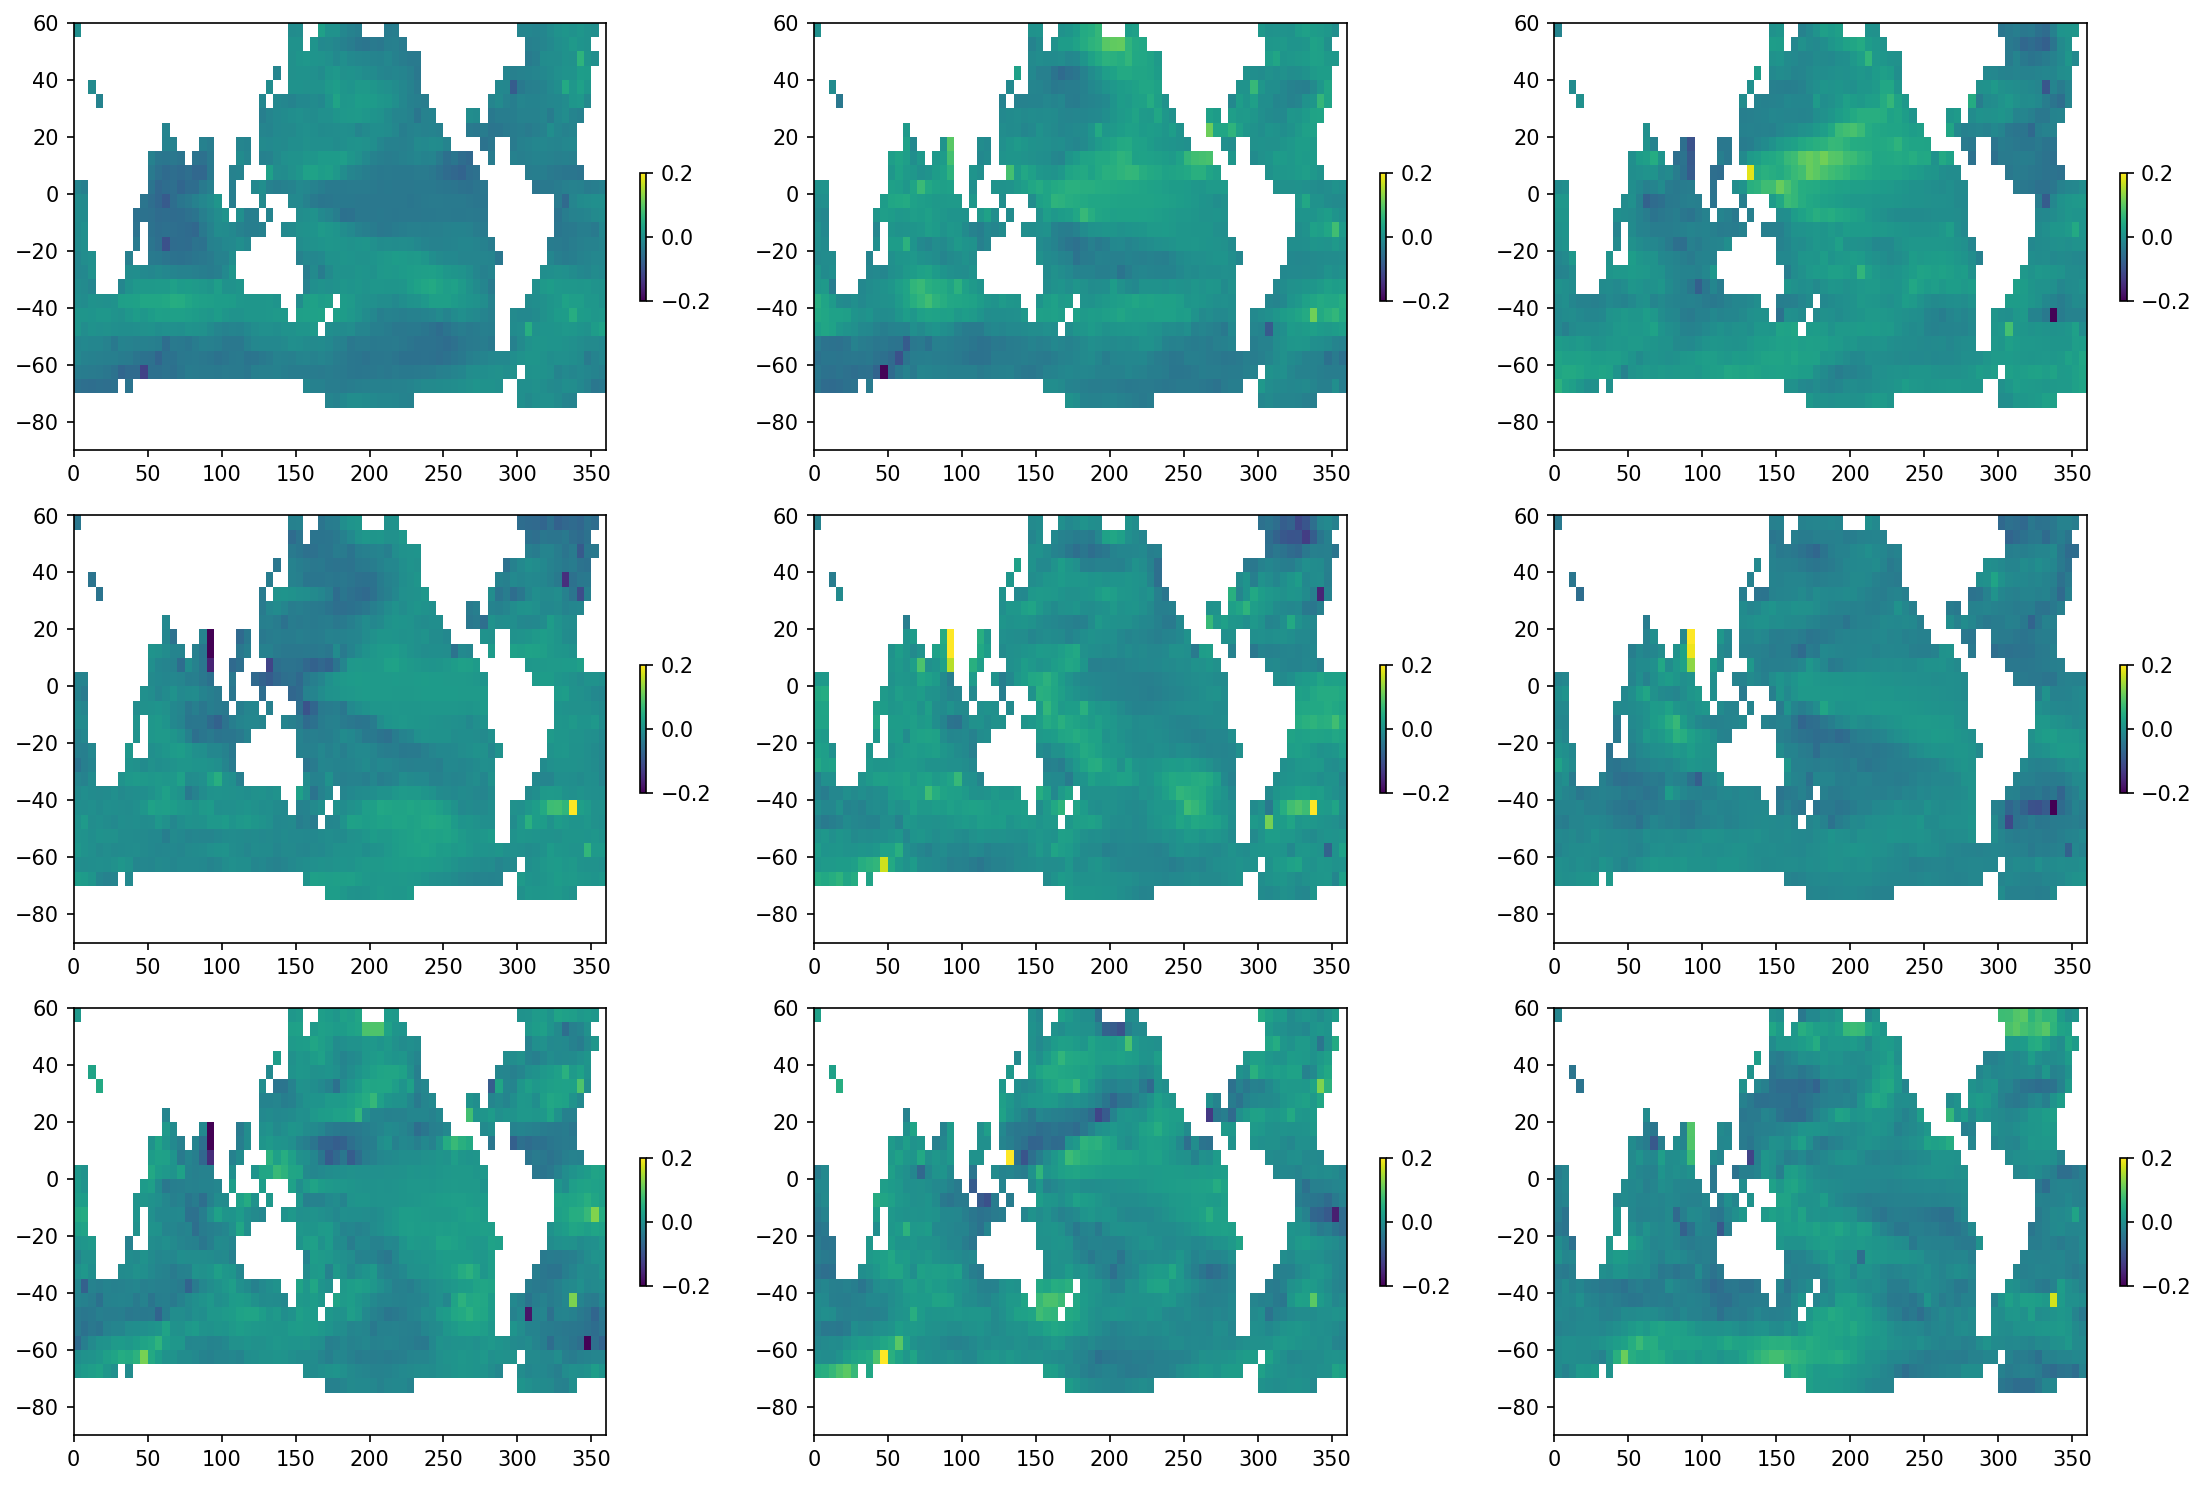

In [52]:
# display 9 first projected components as grid maps 

plt.close('all')
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
vmin = -0.2
vmax = 0.2
for i in range(9):
    ax_i = ax[i // 3, i % 3]
    im = ax_i.pcolormesh(lon_grid, lat_grid, V[:, i].detach().numpy().reshape(lat_size, lon_size), vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax_i, shrink=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# w_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
#                                          lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                          method='robust',rank=None,lambda_=100.0,mu_=1000.0,\
#                                          lr=1e-5,nb_gradient_iterations=5,verbose=True)

In [ ]:
# lambda_tmp = 100.0
# mu_tmp = 1000.0
# rank_tmp = 10

# W_ridge, rmse_mean_ridge, weights_ridge = leave_one_out_procedure(x,y,vars,\
#                                                                 lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                 method='ridge',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                 lr=1e-5,nb_gradient_iterations=50,verbose=True,dtype=dtype)

In [ ]:
# W_rrr, rmse_mean_rrr, training_loss_rrr, weights_rrr = leave_one_out_procedure(x,y,vars,\
#                                                                             lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                             method='rrr',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                             lr=1e-5,nb_gradient_iterations=50,verbose=True,dtype=dtype)

In [ ]:
# W_robust, rmse_mean_robust, weights_robust = leave_one_out_procedure(x,y,vars,\
#                                                                     lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                     method='robust',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                     lr=1e-5,nb_gradient_iterations=100,verbose=True)

In [ ]:
# W_robust_rrr, rmse_mean_robust_rrr, weights_robust_rrr = leave_one_out_procedure(x,y,vars,\
#                                                                                     lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                                     method='robust',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                                     lr=1e-5,nb_gradient_iterations=100,verbose=True)

In [ ]:
# ################### Ridge regresssion ########################
# # compute the ridge loo
# rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# # worst loo Ridge
# worst_loo_ridge = np.max(rmse_ridge_tmp)
# mean_loo_ridge = np.mean(rmse_ridge_tmp)


# # quantile 95, 90, 75
# q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
# q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
# q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
# q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


# ######################## compute the ridge rrr ######################
# rmse_rrr_tmp =  np.array(list(rmse_mean_rrr.values()))

# # worst loo Ridge
# worst_loo_rrr = np.max(rmse_rrr_tmp)
# mean_loo_rrr = np.mean(rmse_rrr_tmp)


# # quantile 95, 90, 75
# q_loo_95_rrr = np.quantile(rmse_rrr_tmp, 0.95)
# q_loo_90_rrr = np.quantile(rmse_rrr_tmp, 0.90)
# q_loo_75_rrr = np.quantile(rmse_rrr_tmp, 0.75)
# q_loo_50_rrr = np.quantile(rmse_rrr_tmp, 0.5)


# ######################## compute the robust regression ######################
# rmse_robust_tmp =  np.array(list(rmse_mean_robust.values()))

# # worst loo Ridge
# worst_loo_robust = np.max(rmse_robust_tmp)
# mean_loo_robust = np.mean(rmse_robust_tmp)


# # quantile 95, 90, 75
# q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
# q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
# q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
# q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

# ######################## compute the robust regression with low rank constraint ######################
# rmse_robust_rrr =  np.array(list(rmse_mean_robust_rrr.values()))

# # worst loo Ridge
# worst_loo_robust_rrr = np.max(rmse_robust_rrr)
# mean_loo_robust_rrr = np.mean(rmse_robust_rrr)


# # quantile 95, 90, 75
# q_loo_95_robust_rrr = np.quantile(rmse_robust_rrr, 0.95)
# q_loo_90_robust_rrr = np.quantile(rmse_robust_rrr, 0.90)
# q_loo_75_robust_rrr = np.quantile(rmse_robust_rrr, 0.75)
# q_loo_50_robust_rrr = np.quantile(rmse_robust_rrr, 0.5)


# print("======= Statistics ========")
# print("\n")
# print("          Ridge   RR-Lr   Robust  Robust-Lr")
# print("Worst:    {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(worst_loo_ridge,worst_loo_rrr,worst_loo_robust, worst_loo_robust_rrr))
# print("0.95:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_95_ridge,q_loo_95_rrr,q_loo_95_robust, q_loo_95_robust_rrr))
# print("0.90:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_90_ridge,q_loo_90_rrr,q_loo_90_robust, q_loo_90_robust_rrr))
# print("0.75:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_75_ridge,q_loo_75_rrr,q_loo_75_robust, q_loo_75_robust_rrr))
# print("Median:   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_50_ridge,q_loo_50_rrr,q_loo_50_robust, q_loo_50_robust_rrr))
# print("Mean:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(mean_loo_ridge,mean_loo_rrr,mean_loo_robust, mean_loo_robust_rrr))

In [ ]:
# w, rmse, training_loss, weights = cross_validation_procedure(x,y,vars,\
#                                                            lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                                            method='robust', rank=None, lambda_range=torch.tensor([100.0]), mu_range=torch.tensor([1000.0]),\
#                                                            lr=1e-5,nb_gradient_iterations=100,verbose=True)